# Neuroevolution

<a rel="license" href="http://creativecommons.org/licenses/by-sa/4.0/"><img alt="Creative Commons License" align="left" src="https://i.creativecommons.org/l/by-sa/4.0/80x15.png" /></a>&nbsp;| Dennis G. Wilson | <a href="https://supaerodatascience.github.io/stochastic/">https://supaerodatascience.github.io/stochastic/</a>

This notebook was optimized for Google colab.

In [1]:
!apt-get install -y xvfb python-opengl swig > /dev/null 2>&1

In [2]:
!pip install swig > /dev/null 2>&1

In [3]:
!pip install xvfbwrapper

Defaulting to user installation because normal site-packages is not writeable
  Using cached xvfbwrapper-0.2.9.tar.gz (5.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for xvfbwrapper: filename=xvfbwrapper-0.2.9-py3-none-any.whl size=5008 sha256=6d1ac93c55ff97d42fde3a477aae55d416bfb4d33da9cd53194f52611e221a0f
  Stored in directory: /home/raphi/.cache/pip/wheels/e1/da/b4/57ac130c024104997ae76f389fe0e7e43922ec3cfdffaf1b1e
Successfully built xvfbwrapper
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: gpg 1.13.1-unknown has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of gpg or 

In [4]:
!pip install cma pyvirtualdisplay gymnasium[box2d]

Defaulting to user installation because normal site-packages is not writeable
  Using cached cma-3.3.0-py3-none-any.whl (260 kB)
  Using cached box2d-py-2.3.5.tar.gz (374 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.0/14.0 MB 1.4 MB/s eta 0:00:0000:0100:010m
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 2.8 MB/s eta 0:00:0000:0100:01m
  Created wheel for box2d-py: filename=box2d_py-2.3.5-cp38-cp38-linux_x86_64.whl size=2834281 sha256=770ac68ba810f79a9177ddf71be7612a5bc6ebf426955380e373be2cd2dc754f
  Stored in directory: /home/raphi/.cache/pip/wheels/8b/95/16/1dc99ff9a3f316ff245fdb5c9086cd13c35dad630809909075
Successfully built box2d-py
DEPRECATION: distro-info 0.23ubuntu1 has a non-standard version number. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of distro-info or contact the author to suggest that they release a version with a conforming version number. Discussion ca

Consider a task where sequential decisions must be made. A common model is to consider that an environment gives an observation for each decision, or action, taken. We can then make decisions by choosing a function which takes in an environment state and gives out an action.

<img src="https://raw.githubusercontent.com/SupaeroDataScience/stochastic/master/notebooks/imgs/ne_basics.png">

Evolutionary strategies are intended for continuous optimization and can easily be applied to the optimization of neural network parameters, or *neuroevolution*. The goal of this is to optimize the parameters of a function which can interact in an environment. A neural network can represent any function, so we can use it as a representation of our decision making function. The parameters of the neural network become the individual we are optimizing.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
import numpy as np
import gymnasium

In [6]:
class NeuralNetwork(nn.Module):

    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()
        self.l1 = nn.Linear(input_shape, 32)
        self.l2 = nn.Linear(32, 32)
        self.lout = nn.Linear(32, n_actions)

    def forward(self, x):
        x = F.relu(self.l1(x.float()))
        x = F.relu(self.l2(x))
        return self.lout(x)

    def get_params(self):
        p = np.empty((0,))
        for n in self.parameters():
            p = np.append(p, n.flatten().cpu().detach().numpy())
        return p

    def set_params(self, x):
        start = 0
        for p in self.parameters():
            e = start + np.prod(p.shape)
            p.data = torch.FloatTensor(x[start:e]).reshape(p.shape)
            start = e

We'll add some visualization functionality to have the environment render directly in the notebook. To run this notebook in Google colab, uncomment and run the following lines.

In [7]:
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline
plt.ion();

Following the framework of evolutionary policy search, we will optimize a neural network representing a policy and maximize the total reward over a single episode using this policy. In the following function, we use the policy function to take actions and calculate a reward given by the environment.

In [8]:
def evaluate(ann, env, visul=True):
    # set the environment
    obs, info = env.reset(seed=0, options={})
    # visualization
    if visul:
        img = plt.imshow(env.render())
    # total reward, objective for maximizing
    total_reward = 0
    # run the sequence of decisions
    done = False
    while not done:
        # Use the neural network to make a decision based on observations
        net_output = ann(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        # take a step in the environment
        obs, reward, done, _, _ = env.step(action)
        # track the total reward
        total_reward += reward
        # visualization of the action
        if visul:
            img.set_data(env.render())
            plt.axis('off')
            display.display(plt.gcf())
            display.clear_output(wait=True)
    return total_reward

We've configured this for discrete action spaces. We can see a random neural network on different environments like `CartPole-v0`, `MountainCar-v0`, and `LunarLander-v2`.

In [9]:
env = gymnasium.make("LunarLander-v2", render_mode="rgb_array")
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

-119.05959591305864

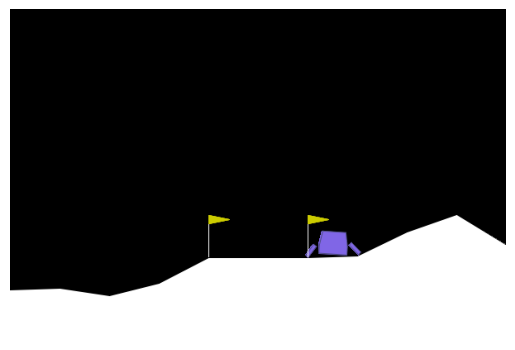

In [10]:
evaluate(ann, env, visul=True)

In order to evolve the parameters of this neural network, we will modify the parameters of the network using `set_params` with the genes of the new individual. In the evolutionary literature, this is referred to as a *direct encoding* as the neural network parameters are directly encoded in the genome.

In [11]:
def fitness(x, ann, env, visul=False):
    ann.set_params(x)
    return -evaluate(ann, env, visul=visul)

In [12]:
p = ann.get_params()
np.shape(p)

(1476,)

We can first observe a random individual $x$.

-119.05959591305864

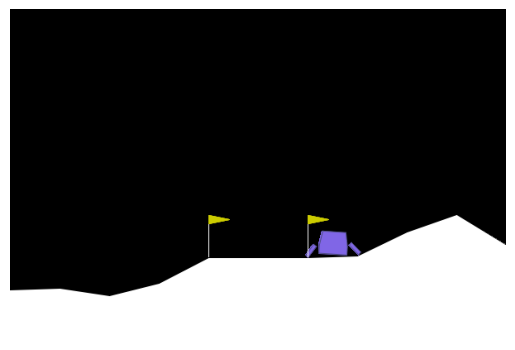

In [15]:
x = np.random.rand(len(p))
-fitness(x, ann, env, visul=True)

# CMA-ES for Neuroevolution

We will now use CMA-ES for the Lunar Lander problem using the pycma package (https://github.com/CMA-ES/pycma)

In [16]:
import cma

In [17]:
np.random.seed(123)
env = gymnasium.make('LunarLander-v2')
ann = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
es = cma.CMAEvolutionStrategy(len(ann.get_params()) * [0], 0.1, {'seed': 123})

(12_w,25)-aCMA-ES (mu_w=7.3,w_1=23%) in dimension 1476 (seed=123, Fri Oct 20 03:02:53 2023)


In [18]:
for i in range(20):
    solutions = np.array(es.ask())
    fits = [fitness(x, ann, env) for x in solutions]
    es.tell(solutions, fits)
    es.disp()

Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     25 -2.200069783769990e+00 1.0e+00 9.94e-02  1e-01  1e-01 0:00.5
    2     50 1.190595959130586e+02 1.0e+00 9.89e-02  1e-01  1e-01 0:01.0
    3     75 1.190595959130586e+02 1.0e+00 9.84e-02  1e-01  1e-01 0:01.5
   10    250 -1.632304515341357e+01 1.0e+00 9.54e-02  1e-01  1e-01 0:04.5
   16    400 2.817770775794870e+01 1.0e+00 9.33e-02  9e-02  9e-02 0:08.7


29.67061082319202

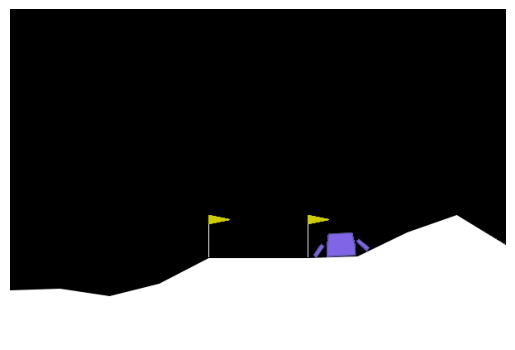

In [19]:
x = es.result[0]
env = gymnasium.make('LunarLander-v2', render_mode="rgb_array")
-fitness(x, ann, env, visul=True)

The results on LunarLander clearly show the benefits of CMA-ES; we have found a reasonable policy in a small number of generations. Applying CMA-ES to larger neural networks remains an open challenge, however, due to the vast number of parameters in ANNs. Specifically, CMA-ES calculates the covariance of all parameters, which is $O(n^2)$.

In [20]:
np.shape(es.sm.C)

(1476, 1476)